In [7]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, log_loss
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Models
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [8]:
# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

In [9]:
# -----------------------------------------------
# LOAD DATASETS
# -----------------------------------------------
train_df = pd.read_csv("/kaggle/input/mock-test-2-mse-2/train.csv")
test_df = pd.read_csv("/kaggle/input/mock-test-2-mse-2/test.csv")
sample_submission = pd.read_csv("/kaggle/input/mock-test-2-mse-2/sample_submission.csv")

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)
print("Sample submission shape:", sample_submission.shape)

Train shape: (15000, 20)
Test shape: (10000, 19)
Sample submission shape: (10000, 4)


In [10]:
# -----------------------------------------------
# TARGET (assumed last column)
# -----------------------------------------------
target = train_df.columns[-1]

X = train_df.drop(columns=[target])
y_raw = train_df[target]

le = LabelEncoder()
y = le.fit_transform(y_raw)

X_test_final = test_df.copy()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


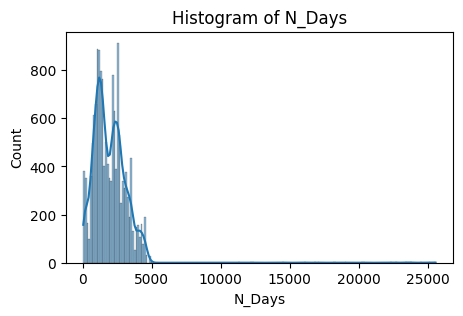

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


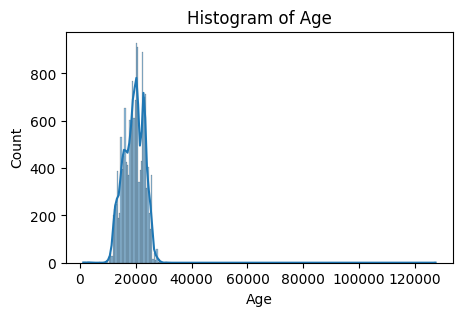

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


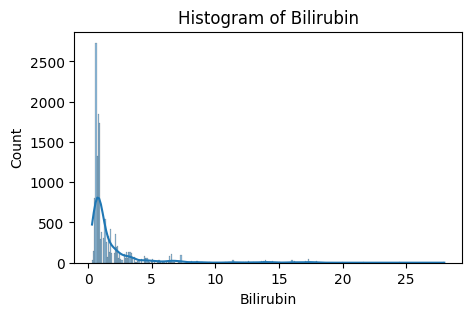

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


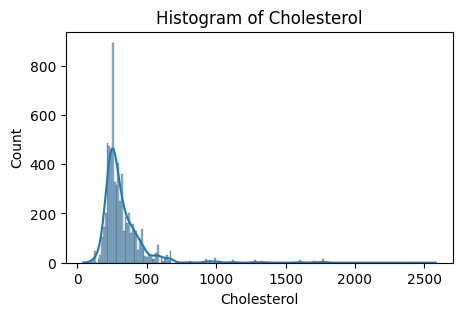

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


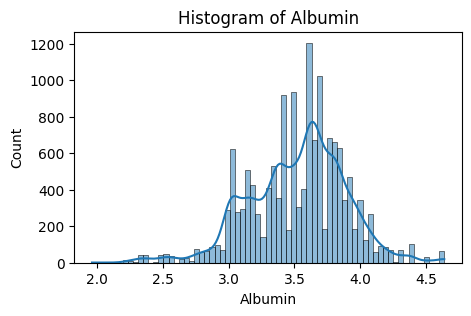

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


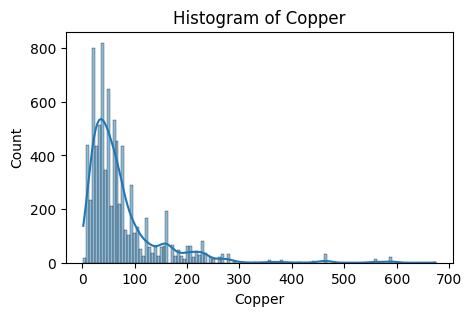

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


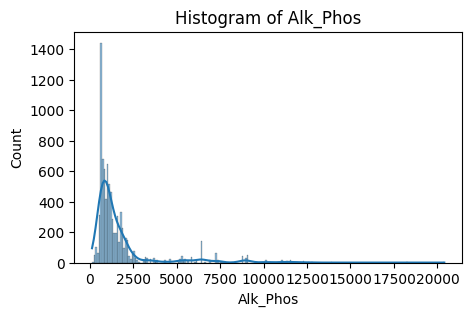

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


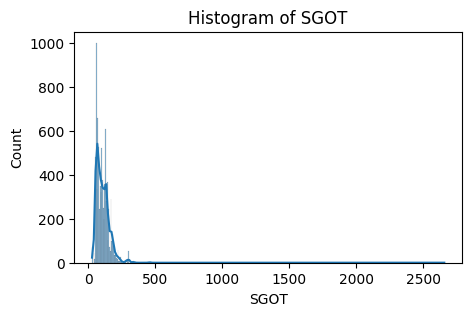

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


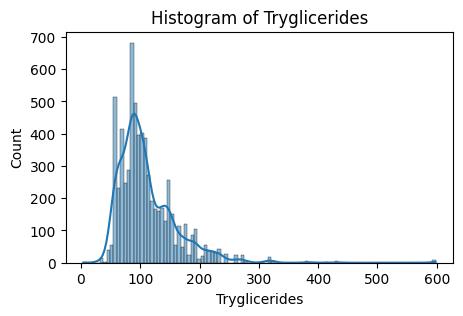

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


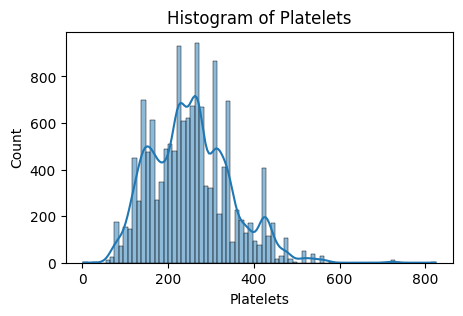

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


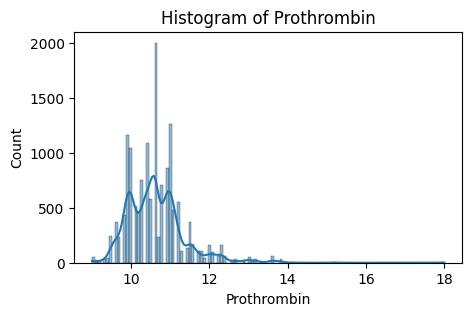

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


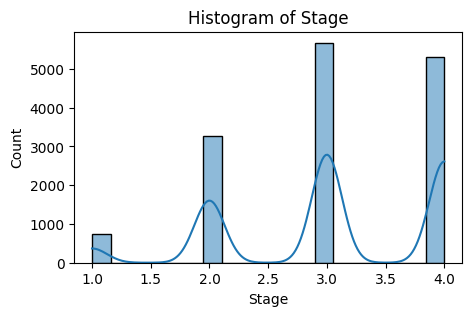

In [11]:
# -----------------------------------------------
# ================= VISUALIZATION =================
# -----------------------------------------------

num_cols_viz = X.select_dtypes(include=np.number).columns
num_cols_viz = num_cols_viz.drop("id", errors="ignore")

# 🔹 Histograms
for col in num_cols_viz:
    plt.figure(figsize=(5,3))
    sns.histplot(train_df[col], kde=True)
    plt.title(f"Histogram of {col}")
    plt.show()

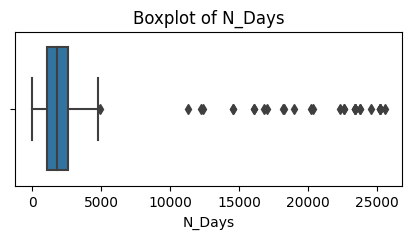

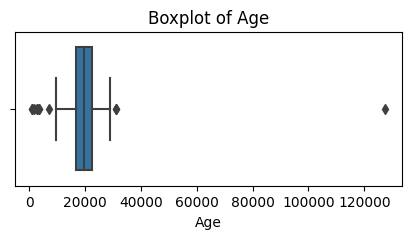

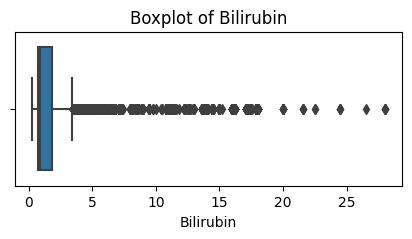

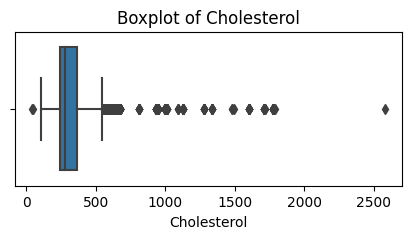

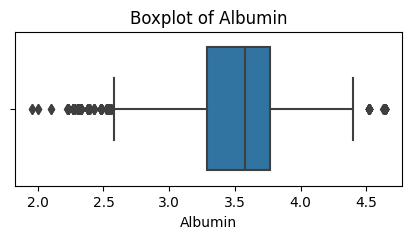

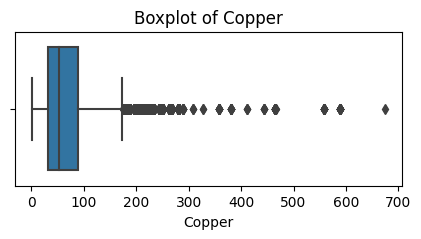

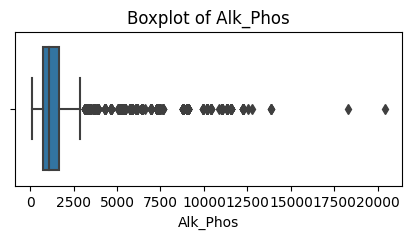

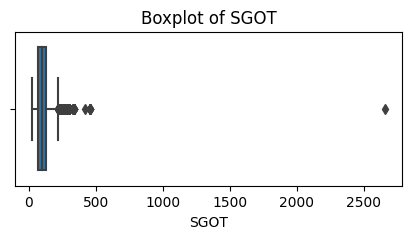

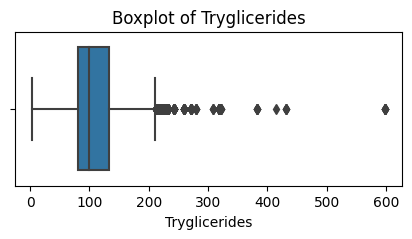

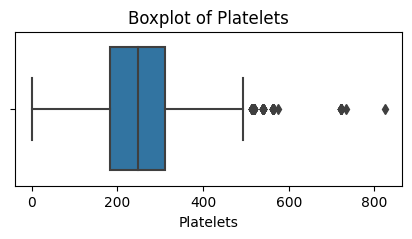

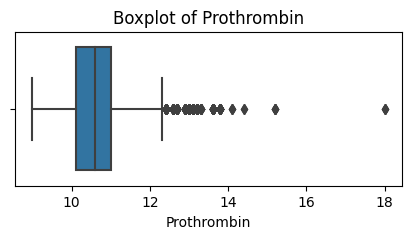

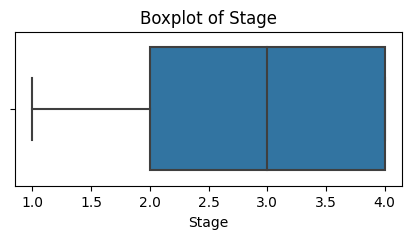

In [12]:
# 🔹 Boxplots (Outlier visualization)
for col in num_cols_viz:
    plt.figure(figsize=(5,2))
    sns.boxplot(x=train_df[col])
    plt.title(f"Boxplot of {col}")
    plt.show()

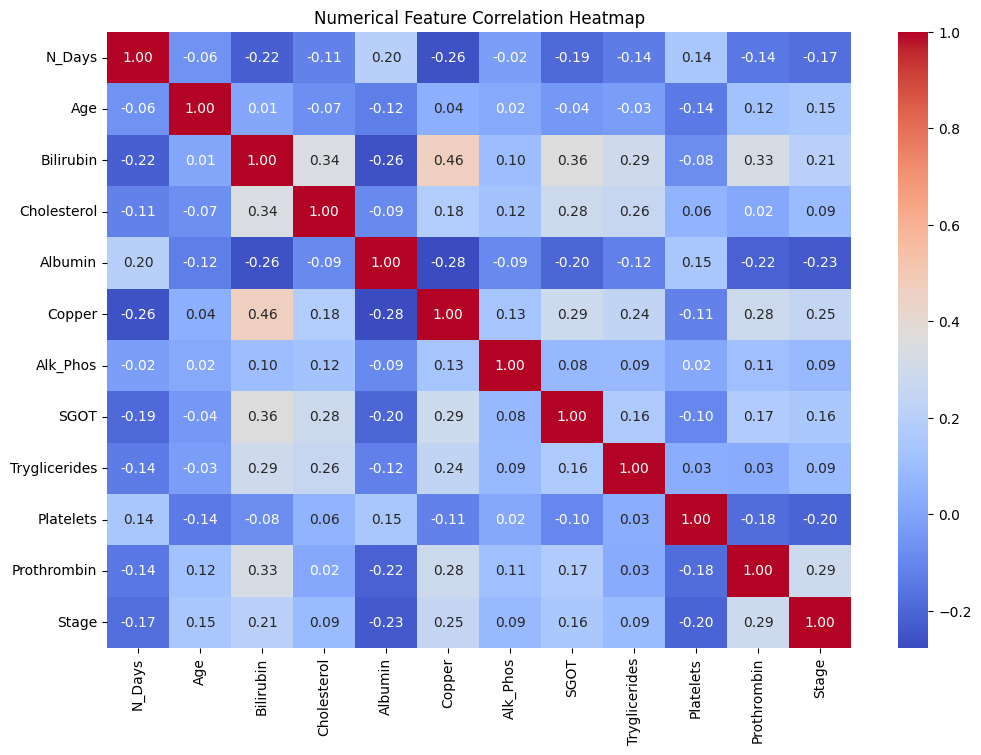

In [13]:
# 🔹 Correlation heatmap
plt.figure(figsize=(12,8))
sns.heatmap(train_df[num_cols_viz].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Numerical Feature Correlation Heatmap")
plt.show()

In [14]:
# -----------------------------------------------
# OUTLIER HANDLING (IQR METHOD)
# -----------------------------------------------
num_cols_out = X.select_dtypes(include=np.number).columns
num_cols_out = num_cols_out.drop("id", errors="ignore")

for col in num_cols_out:
    Q1 = X[col].quantile(0.25)
    Q3 = X[col].quantile(0.75)
    IQR = Q3 - Q1

    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    X[col] = np.where(X[col] < lower, lower, X[col])
    X[col] = np.where(X[col] > upper, upper, X[col])

    if col in X_test_final.columns:
        X_test_final[col] = np.where(X_test_final[col] < lower, lower, X_test_final[col])
        X_test_final[col] = np.where(X_test_final[col] > upper, upper, X_test_final[col])

/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: Ru

In [15]:
# -----------------------------------------------
# TRAIN–VALIDATION SPLIT
# -----------------------------------------------
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [17]:
# -----------------------------------------------
# DETECT COLUMN TYPES
# -----------------------------------------------
cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()
num_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()

# -----------------------------------------------

In [19]:
# PREPROCESSOR
# -----------------------------------------------
preprocess = ColumnTransformer(
    transformers=[
        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(handle_unknown="ignore"))
        ]), cat_cols),

        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="mean")),
            ("scaler", StandardScaler())
        ]), num_cols),
    ]
)

In [20]:
# -----------------------------------------------
# MODELS (MULTICLASS SAFE)
# -----------------------------------------------
models = {
    "XGBoost": XGBClassifier(
        objective="multi:softprob",
        eval_metric="mlogloss",
        n_estimators=400,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        n_jobs=-1
    ),
    "LightGBM": LGBMClassifier(
        objective="multiclass",
        n_estimators=400,
        learning_rate=0.05,
        n_jobs=-1
    ),
    "CatBoost": CatBoostClassifier(
        loss_function="MultiClass",
        eval_metric="MultiClass",
        iterations=500,
        learning_rate=0.05,
        depth=6,
        verbose=0
    ),
    "RandomForest": RandomForestClassifier(
        n_estimators=400,
        n_jobs=-1
    ),
    "LogisticRegression": LogisticRegression(
        max_iter=2000,
        n_jobs=-1
    )
}

In [21]:
# -----------------------------------------------
# MODEL TRAINING LOOP
# -----------------------------------------------
best_model = None
best_logloss = np.inf
best_acc = 0.0
best_name = ""

for name, model in models.items():
    print(f"\nTraining {name} ...")

    pipe = Pipeline([
        ("pre", preprocess),
        ("model", model)
    ])

    pipe.fit(X_train, y_train)

    preds = pipe.predict(X_valid)
    prob = pipe.predict_proba(X_valid)

    acc = accuracy_score(y_valid, preds)
    ll = log_loss(y_valid, prob)

    print(f"===== {name} =====")
    print("Accuracy:", acc)
    print("LogLoss :", ll)

    if ll < best_logloss:
        best_logloss = ll
        best_acc = acc
        best_model = pipe
        best_name = name


Training XGBoost ...
===== XGBoost =====
Accuracy: 0.8563333333333333
LogLoss : 0.36795474429335445

Training LightGBM ...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001161 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1987
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 26
[LightGBM] [Info] Start training from score -0.394154
[LightGBM] [Info] Start training from score -3.698930
[LightGBM] [Info] Start training from score -1.200645
===== LightGBM =====
Accuracy: 0.8543333333333333
LogLoss : 0.3895423571975424

Training CatBoost ...
===== CatBoost =====
Accuracy: 0.8603333333333333
LogLoss : 0.3766275964668088

Training RandomForest ...
===== RandomForest =====
Accuracy: 0.8463333333333334
LogLoss : 0.41412347215762935

Training LogisticRegression ...
===== LogisticRegression =====
Accur

In [22]:
# -----------------------------------------------
# BEST MODEL
# -----------------------------------------------
print("\n===============================")
print(" BEST MODEL SELECTED AUTOMATICALLY ")
print("===============================")
print("Model      :", best_name)
print("Accuracy   :", best_acc)
print("LogLoss    :", best_logloss)


 BEST MODEL SELECTED AUTOMATICALLY 
Model      : XGBoost
Accuracy   : 0.8563333333333333
LogLoss    : 0.36795474429335445


In [23]:
# -----------------------------------------------
# FINAL PREDICTIONS (PROBABILITIES)
# -----------------------------------------------
final_prob = best_model.predict_proba(X_test_final)

# -----------------------------------------------
# SUBMISSION (MATCH SAMPLE SUBMISSION)
# -----------------------------------------------
submission = sample_submission.copy()

# Fill probability columns in correct order
for i, class_name in enumerate(le.classes_):
    submission[f"{target}_{class_name}"] = final_prob[:, i]

submission.to_csv("submission_final.csv", index=False)

print("\nsubmission_final.csv saved!")
print(submission.head())


submission_final.csv saved!
      id  Status_C  Status_CL  Status_D
0  15000  0.985381   0.000556  0.014063
1  15001  0.989752   0.001583  0.008665
2  15002  0.922081   0.007225  0.070694
3  15003  0.146485   0.011301  0.842214
4  15004  0.993293   0.000665  0.006042
